Visualización de muestra biológica translúcida mediante contraste de fase

Campo de visión (Object Size) físico: 390.18 µm
Este campo de visión se mapeará a 720 píxeles.
Pupila Zernike creada: radio_spot=0.10 mm, atenuación=0.75, desfase=1.57 rad


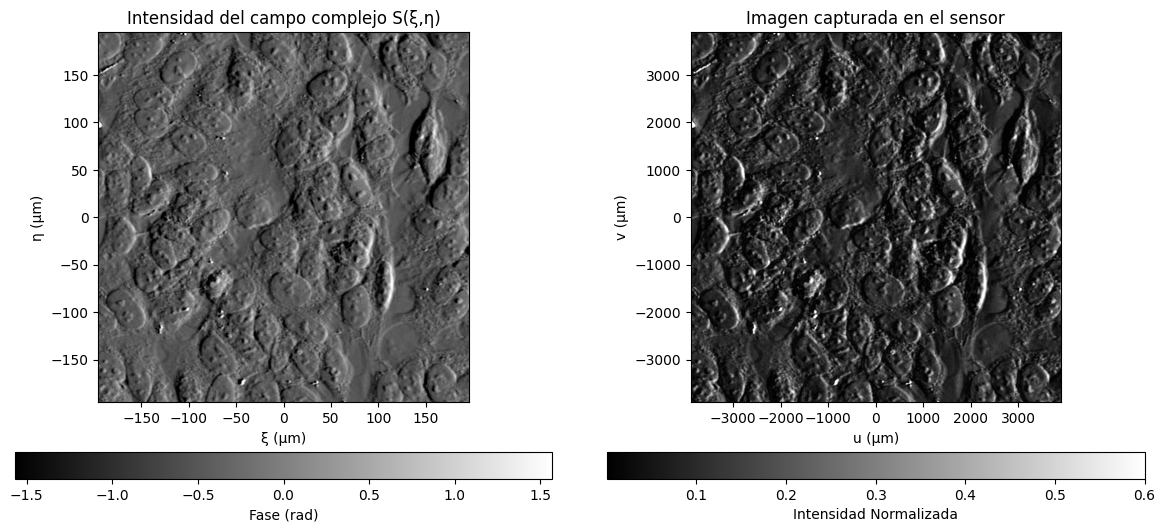

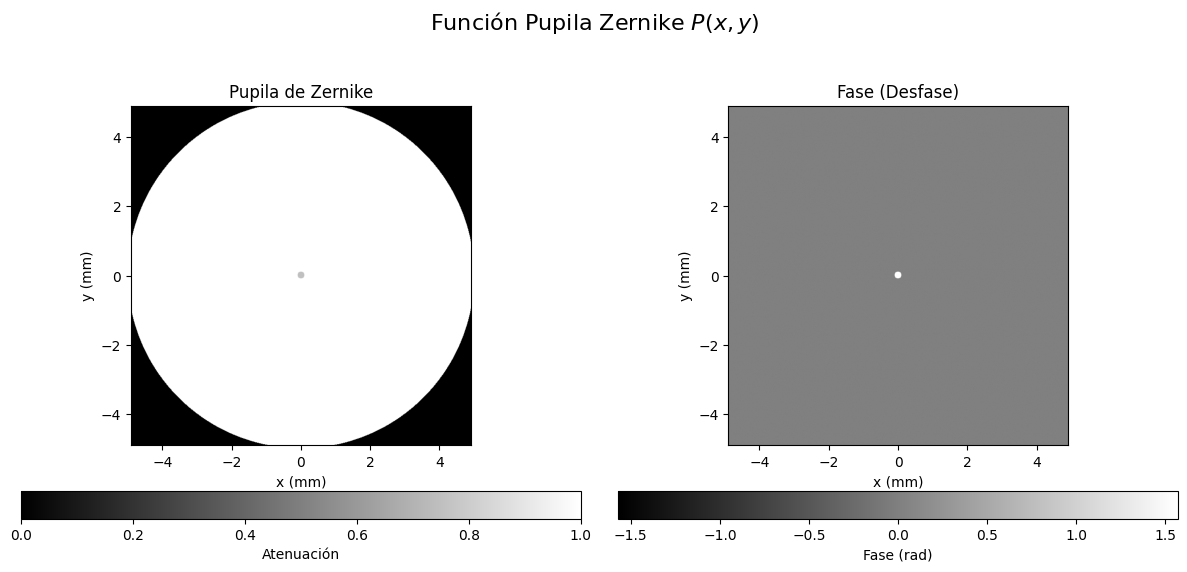

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import io

def load_transmittance(image_path):
    """Carga un archivo (TXT o CSV) que contiene datos complejos."""

    t_xy = None # Campo complejo final

    try:
        # Cargar datos directamente como complejos, delimitados por coma
        t_xy = np.loadtxt(image_path, dtype=np.complex128, delimiter=',')

    except Exception as e:
        # Error simplificado si numpy no puede leer el archivo
        raise IOError(f"Error al cargar TXT/CSV como complejo. Error: {e}")

    return t_xy

def create_zernike_pupil_mask(pixel_count, pupil_plane_size_m, pupil_radius_m, pupil_config):
    """
    Pupila de Contraste de Fase Zernike.

    pupil_config (dict): Contiene los parámetros del filtro Zernike.
        'spot_radius_fraction' (float): Radio del punto de fase como fracción del radio de la pupila.
        'attenuation' (float): Factor de atenuación de amplitud en el punto.
        'phase_shift' (float): Desfase en radianes.
    """
    spot_radius_fraction = pupil_config.get('spot_radius_fraction', 0.1)
    attenuation = pupil_config.get('attenuation', 0.25)
    phase_shift_rad = pupil_config.get('phase_shift', np.pi / 2.0)

    # 1. Crear rejilla de coordenadas de la pupila
    pupil_coords = np.linspace(-pupil_plane_size_m/2, pupil_plane_size_m/2, pixel_count)
    X_p, Y_p = np.meshgrid(pupil_coords, pupil_coords)
    R_p_grid = np.sqrt(X_p**2 + Y_p**2)

    # 2. Empezar con la pupila de campo claro (Apertura)
    pupil_function = np.zeros((pixel_count, pixel_count), dtype=complex)
    pupil_function[R_p_grid < pupil_radius_m] = 1.0 + 0.0j

    # 3. Definir el "punto" de fase Zernike
    spot_radius_m = spot_radius_fraction * pupil_radius_m
    spot_mask = R_p_grid < spot_radius_m

    # 4. Calcular el valor complejo del punto de fase
    spot_value = attenuation * np.exp(1j * phase_shift_rad)

    # 5. Sobrescribir el centro de la pupila con el valor del punto
    final_spot_mask = spot_mask & (R_p_grid < pupil_radius_m)
    pupil_function[final_spot_mask] = spot_value

    print(f"Pupila Zernike creada: radio_spot={spot_radius_m*1e3:.2f} mm, atenuación={attenuation}, desfase={phase_shift_rad:.2f} rad")

    return pupil_function


def simulate_system(input_object, object_size_m, pixel_count, wavelength, f_MO, f_TL, pupil_radius_m,
                    pupil_config):
    """Simula la formación de imagen en un sistema 4f (microscopio)
    con contraste de fase Zernike."""

    # 1. Calcular la escala del plano de la pupila (Plano de Fourier)
    dx_object = object_size_m / pixel_count
    pupil_plane_size_m = (wavelength * f_MO) / dx_object

    # 2. Crear la pupila Zernike
    pupil_function = create_zernike_pupil_mask(
        pixel_count, pupil_plane_size_m, pupil_radius_m, pupil_config
    )

    # 3. Simular la propagación y el filtrado

    # Etapa 1: Objeto -> Plano Focal (Pupila)
    object_spectrum = np.fft.fft2(np.fft.ifftshift(input_object))

    # Etapa 2: Filtrado Espacial
    filtered_spectrum = object_spectrum * np.fft.fftshift(pupil_function)

    # Etapa 3: Plano Focal (Pupila) -> Plano Imagen (Cámara)
    output_field = np.fft.fftshift(np.fft.ifft2(filtered_spectrum))

    # 4. Calcular magnificación y escala de la imagen final
    magnification = f_TL / f_MO
    image_plane_size_m = object_size_m * magnification

    return output_field, image_plane_size_m, pupil_function, pupil_plane_size_m


# Parámetros del Sistema Físico
wavelength = 533e-9      # Longitud de onda (533 nm)
f_mo = 0.01              # Focal Objetivo (10 mm)
f_tl = 0.2               # Focal Lente de Tubo (200 mm)
na_mo = 0.5              # Apertura Numérica del objetivo (0.5)

magnification = f_tl / f_mo # Magnificación (20x)

# Parámetros Físicos del Sensor
dx_sensor = 2.74e-6 # pixel size (2.74 µm)
pixel_count_sensor = 2848  # N


# Cargar el Objeto de Prueba
filename = 'MuestraBio_E08.txt'

# Cargar el objeto complejo desde el TXT
U0_data = load_transmittance(filename)
pixel_count = U0_data.shape[0]


# Calcular tamaños físicos
sensor_size_m = pixel_count_sensor * dx_sensor
object_size_m = sensor_size_m / magnification
pupil_radius_m = na_mo * f_mo

print(f"Campo de visión (Object Size) físico: {object_size_m * 1e6:.2f} µm")
print(f"Este campo de visión se mapeará a {pixel_count} píxeles.")

U0 = U0_data


# Configuración de Pupila Zernike --> Importante, variar parámetros acá

zernike_config = {
    'spot_radius_fraction': 0.02,  # 10% de la pupila
    'attenuation': 0.75,          # 25% de transmisión de amplitud
    'phase_shift': np.pi / 2
}


output_field, image_plane_size_m, pupil_mask, pupil_plane_size_m = simulate_system(
    U0, object_size_m, pixel_count, wavelength, f_mo, f_tl, pupil_radius_m,
    pupil_config=zernike_config
)

# Detección de la Imagen (Intensidad)
intensity = np.abs(output_field)**2
intensity = intensity / np.max(intensity)

# Resultados

output_dir = "output_imagenes_zernike"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extensión del objeto
extent_obj_um = [-object_size_m/2 * 1e6, object_size_m/2 * 1e6, -object_size_m/2 * 1e6, object_size_m/2 * 1e6]

# Guardar campo - objeto original TXT
plt.figure(figsize=(6, 5))
plt.imshow(np.angle(U0), cmap='gray', extent=extent_obj_um)
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')
plt.colorbar(label='Fase (rad)')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fig0_objeto.png"), dpi=300)
plt.close() # Cerrar la figura para que no se muestre


# --- Figura 1: Comparación Objeto (Fase) vs Imagen (Intensidad) ---
plt.figure(figsize=(12, 6))


# Subplot 1: Fase del Objeto Original
plt.subplot(1, 2, 1)
plt.imshow(np.angle(U0), cmap='gray', extent=extent_obj_um)
plt.title(f'Intensidad del campo complejo S(ξ,η)')
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')
plt.colorbar(label='Fase (rad)', orientation='horizontal', pad=0.1)


# Subplot 2: Imagen en el sensor

extent_cam_um = [-image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6, -image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6]
plt.subplot(1, 2, 2)
plt.imshow(intensity, cmap='gray', extent=extent_cam_um, vmax=0.6)
plt.title('Imagen capturada en el sensor')
plt.xlabel('u (μm)')
plt.ylabel('v (μm)')
plt.colorbar(label='Intensidad Normalizada', orientation='horizontal', pad=0.1)


plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.savefig(os.path.join(output_dir, "fig1_campo_vs_imagen.png"), dpi=300)
plt.show()

# Detalles de la Pupila Zernike
plt.figure(figsize=(12, 6))
plt.suptitle('Función Pupila Zernike $P(x,y)$', fontsize=16)

# Coordenadas y zoom de la pupila
extent_pup_mm = [-pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000, -pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000]
zoom_limit_mm = pupil_radius_m * 0.98 * 1000 # Zoom

# Subplot
plt.subplot(1, 2, 1)
plt.imshow(np.abs(pupil_mask), cmap='gray', extent=extent_pup_mm, vmin=0, vmax=1)
plt.title('Pupila de Zernike')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm)
plt.colorbar(label='Atenuación', orientation='horizontal', pad=0.1)

# Subplot 2: Fase de la Pupila
plt.subplot(1, 2, 2)
plt.imshow(np.angle(pupil_mask), cmap='gray', extent=extent_pup_mm, vmin=-np.pi/2, vmax=np.pi/2)
plt.title('Fase (Desfase)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm) # Corregido
plt.colorbar(label='Fase (rad)', orientation='horizontal', pad=0.1)

plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.savefig(os.path.join(output_dir, "fig2_pupila_zernike.png"), dpi=300)
plt.show()


Script de descarga de imágenes individuales

Carga de objeto complejo completada. Dimensiones: (720, 720)
Campo de visión (Object Size) asignado: 390.18 µm
Tamaño de pixel del objeto (dx_obj): 0.5419 µm
N de simulación (pixel_count): 720
Pupila Zernike creada: radio_spot=0.01 mm, atenuación=0.956, desfase=1.57 rad


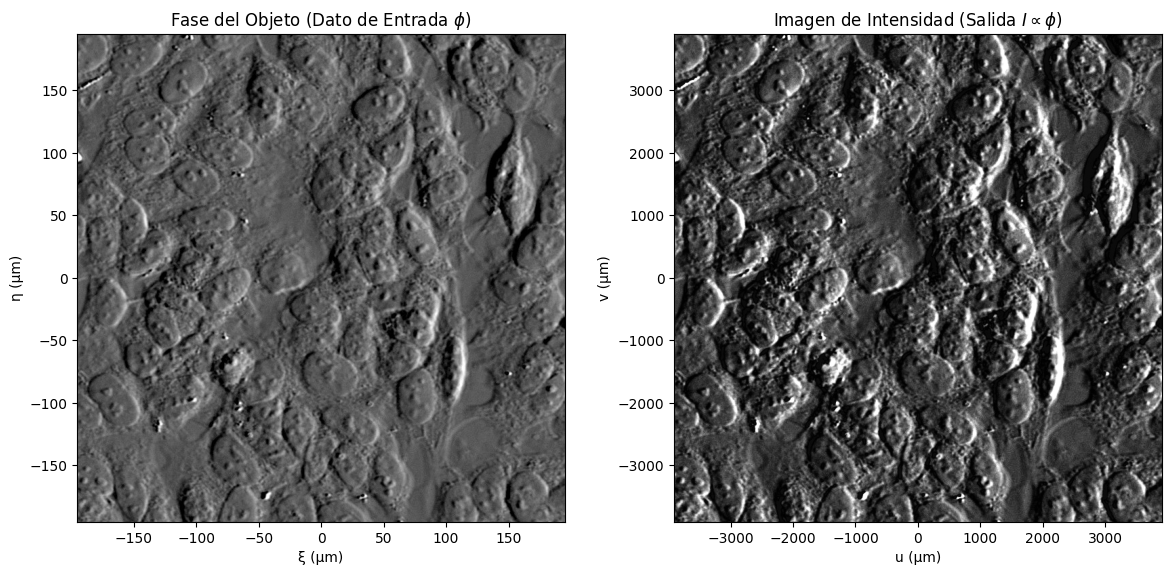

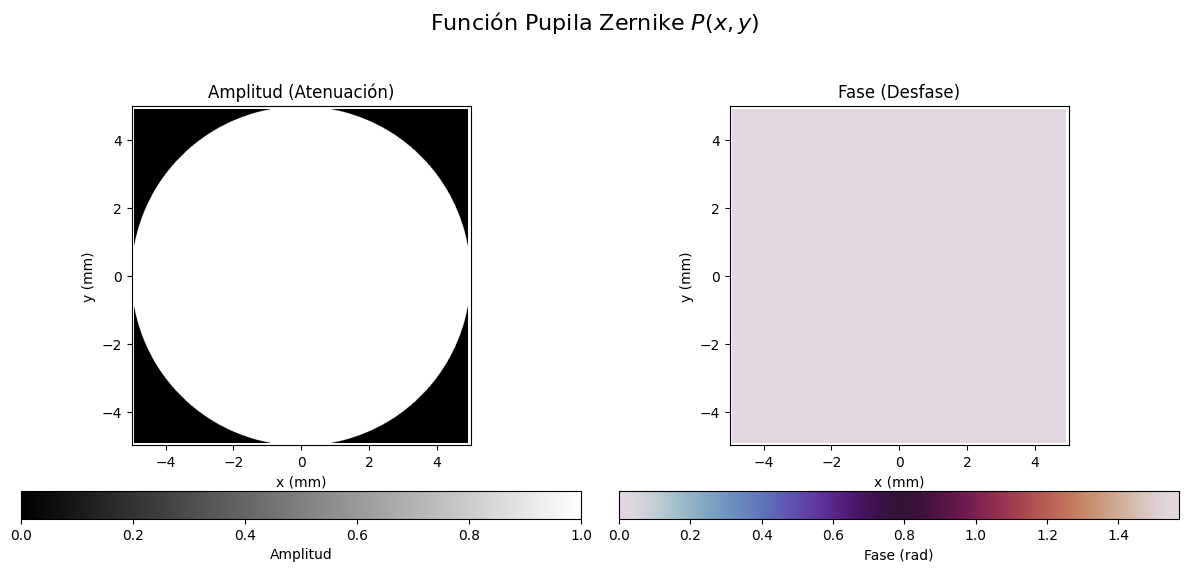

Generando close-ups de 170 µm de ancho...
Close-ups guardados en: output_imagenes_contraste_fase
Simulación de contraste de fase completada.
Imágenes individuales guardadas en: output_imagenes_contraste_fase


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os
import io

# --- FUNCIÓN DE CARGA (Simplificada y Modificada) ---
def load_transmittance(image_path):
    """
    Carga un archivo (TXT o CSV) que contiene datos complejos.
    Se asume que el archivo existe, tiene el formato correcto (delimitado por comas)
    y es una matriz 2D cuadrada.
    """

    t_xy = None # Campo complejo final

    try:
        # Cargar datos directamente como complejos, delimitados por coma
        t_xy = np.loadtxt(image_path, dtype=np.complex128, delimiter=',')

        print(f"Carga de objeto complejo completada. Dimensiones: {t_xy.shape}")

        if t_xy.ndim != 2 or t_xy.shape[0] != t_xy.shape[1]:
             raise ValueError(f"El archivo cargado no es una matriz 2D cuadrada. Dimensiones: {t_xy.shape}")

    except Exception as e:
        # Error simplificado si numpy no puede leer el archivo
        raise IOError(f"Error al cargar TXT/CSV como complejo. Error: {e}")

    return t_xy

# --- FUNCIÓN DE PUPILA ZERNIKE ---

def create_zernike_pupil_mask(pixel_count, pupil_plane_size_m, pupil_radius_m, pupil_config):
    """
    Crea una pupila de Contraste de Fase Zernike (Positivo).

    pupil_config (dict): Contiene los parámetros del filtro Zernike.
        'spot_radius_fraction' (float): Radio del punto de fase como fracción del radio de la pupila.
        'attenuation' (float): Factor de atenuación de amplitud en el punto (ej. 0.25).
        'phase_shift' (float): Desfase en radianes (ej. np.pi/2 para contraste positivo).
    """
    # Extraer parámetros de configuración
    spot_radius_fraction = pupil_config.get('spot_radius_fraction', 0.1)
    attenuation = pupil_config.get('attenuation', 0.25)
    phase_shift_rad = pupil_config.get('phase_shift', np.pi / 2.0)

    # 1. Crear rejilla de coordenadas de la pupila
    pupil_coords = np.linspace(-pupil_plane_size_m/2, pupil_plane_size_m/2, pixel_count)
    X_p, Y_p = np.meshgrid(pupil_coords, pupil_coords)
    R_p_grid = np.sqrt(X_p**2 + Y_p**2)

    # 2. Empezar con la pupila de campo claro (Apertura)
    # Todo dentro de la pupila es 1.0 + 0.0j
    pupil_function = np.zeros((pixel_count, pixel_count), dtype=complex)
    pupil_function[R_p_grid < pupil_radius_m] = 1.0 + 0.0j

    # 3. Definir el "punto" de fase Zernike
    spot_radius_m = spot_radius_fraction * pupil_radius_m
    spot_mask = R_p_grid < spot_radius_m

    # 4. Calcular el valor complejo del punto de fase
    # (Atenuación * e^(j * desfase))
    spot_value = attenuation * np.exp(1j * phase_shift_rad)

    # 5. Sobrescribir el centro de la pupila con el valor del punto
    pupil_function[spot_mask] = spot_value

    print(f"Pupila Zernike creada: radio_spot={spot_radius_m*1e3:.2f} mm, atenuación={attenuation}, desfase={phase_shift_rad:.2f} rad")

    return pupil_function


# --- SECCIÓN 2: FUNCIÓN DE SIMULACIÓN (Optimizada para Zernike) ---

def simulate_system(input_object, object_size_m, pixel_count, wavelength, f_MO, f_TL, pupil_radius_m,
                    pupil_config):
    """
    Simula la formación de imagen en un sistema 4f (microscopio)
    con contraste de fase Zernike.

    pupil_config (dict): Necesario para configurar la pupila Zernike.
    """

    # 1. Calcular la escala del plano de la pupila (Plano de Fourier)
    dx_object = object_size_m / pixel_count
    pupil_plane_size_m = (wavelength * f_MO) / dx_object

    # 2. Crear la pupila Zernike (el filtro en el plano de Fourier)
    pupil_function = create_zernike_pupil_mask(
        pixel_count, pupil_plane_size_m, pupil_radius_m, pupil_config
    )

    # 3. Simular la propagación y el filtrado (con el 'shift' correcto)

    # Etapa 1: Objeto -> Plano Focal (Pupila)
    object_spectrum = np.fft.fft2(np.fft.ifftshift(input_object))

    # Etapa 2: Filtrado Espacial
    filtered_spectrum = object_spectrum * np.fft.fftshift(pupil_function)

    # Etapa 3: Plano Focal (Pupila) -> Plano Imagen (Cámara)
    output_field = np.fft.fftshift(np.fft.ifft2(filtered_spectrum))

    # 4. Calcular magnificación y escala de la imagen final
    magnification = f_TL / f_MO
    image_plane_size_m = object_size_m * magnification

    return output_field, image_plane_size_m, pupil_function, pupil_plane_size_m



# --- 1. Parámetros del Sistema Físico (sin cambios) ---
wavelength = 533e-9      # Longitud de onda (533 nm)
f_mo = 0.01              # Focal Objetivo (10 mm)
f_tl = 0.2               # Focal Lente de Tubo (200 mm)
na_mo = 0.5              # Apertura Numérica del objetivo (0.5)

magnification = f_tl / f_mo # Magnificación (20x)

# --- 2. Parámetros Físicos del Sensor (FIJOS) ---
dx_sensor = 2.74e-6 # pixel size (2.74 µm)
# --- 3. Cargar el Objeto de Prueba (MODIFICADO) ---
filename = 'MuestraBio_E08.txt'

# Cargar el objeto complejo desde el TXT
U0_data = load_transmittance(filename)
N_data = U0_data.shape[0]


# --- 4. (RE-ORDENADO) Calcular tamaños físicos basados en N de DATOS ---
pixel_count = N_data # N de la simulación = N de los datos
object_size_m = (dx_sensor * 2848) / magnification # 390.176 µm
dx_obj = object_size_m / pixel_count

sensor_size_m = object_size_m * magnification
pupil_radius_m = na_mo * f_mo

print(f"Campo de visión (Object Size) asignado: {object_size_m * 1e6:.2f} µm")
print(f"Tamaño de pixel del objeto (dx_obj): {dx_obj * 1e6:.4f} µm")
print(f"N de simulación (pixel_count): {pixel_count}")


# El campo de entrada es directamente el archivo de datos (SIN PADDING)
U0 = U0_data


# --- 5. Configuración de Pupila Zernike ---
zernike_config = {
    'spot_radius_fraction': 0.002,  # Radio del punto = 10% del radio de la pupila
    'attenuation': 0.956,           # Atenuación de amplitud (T=A^2=0.0625)
    'phase_shift': np.pi / 2      # Desfase de +90 grados (Contraste positivo)
}

# --- (NUEVO) 5b. Configuración de Close-up ---
# Define la región de interés (ROI) para los close-ups.
# Las coordenadas están en micras (µm) en el plano del OBJETO.
closeup_config = {
    'enable': True,            # Poner en True para generar close-ups
    'center_x_um': 50,         # Centro X (ξ) del zoom, en µm
    'center_y_um': 35,        # Centro Y (η) del zoom, en µm
    'width_um': 170           # Ancho total del zoom, en µm
}

# --- 6. Simular el Microscopio 4f ---
output_field, image_plane_size_m, pupil_mask, pupil_plane_size_m = simulate_system(
    U0, object_size_m, pixel_count, wavelength, f_mo, f_tl, pupil_radius_m,
    pupil_config=zernike_config
)

# --- 7. Detección de la Imagen (Intensidad) ---
intensity = np.abs(output_field)**2
intensity = intensity / np.max(intensity)


# --- 7. VISUALIZACIÓN DE RESULTADOS (MODIFICADO) ---

output_dir = "output_imagenes_contraste_fase" # Directorio cambiado
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# --- Definir la extensión del objeto ---
# El tamaño físico (object_size_m) ahora corresponde a los píxeles (pixel_count)
extent_obj_um = [-object_size_m/2 * 1e6, object_size_m/2 * 1e6, -object_size_m/2 * 1e6, object_size_m/2 * 1e6]


# --- Figura 0: Guardar Fase del Objeto Original (Individual) ---
plt.figure(figsize=(6, 5))
plt.imshow(np.angle(U0), cmap='gray', extent=extent_obj_um) # 'twilight' es bueno para fase
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')
plt.colorbar(label='Fase (rad)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fig0_objeto_fase.png"), dpi=300)
plt.close() # Cerrar la figura para que no se muestre


# --- Figura 1: Comparación Objeto (Fase) vs Imagen (Intensidad) ---
plt.figure(figsize=(12, 6))

# Subplot 1: Fase del Objeto Original
plt.subplot(1, 2, 1)
plt.imshow(np.angle(U0), cmap='gray', extent=extent_obj_um)
plt.title(r'Fase del Objeto (Dato de Entrada $\phi$)')
plt.xlabel('ξ (μm)')
plt.ylabel('η (μm)')

# Subplot 2: Imagen en el sensor
# El tamaño físico (image_plane_size_m) ahora corresponde a los píxeles (pixel_count)
extent_cam_um = [-image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6, -image_plane_size_m/2 * 1e6, image_plane_size_m/2 * 1e6]
plt.subplot(1, 2, 2)
# (MODIFICADO) Añadimos vmax para 'estirar' el brillo de la imagen
plt.imshow(intensity, cmap='gray', extent=extent_cam_um, vmax=0.6)
plt.title(r'Imagen de Intensidad (Salida $I \propto \phi$)') # <-- Título ajustado
plt.xlabel('u (μm)')
plt.ylabel('v (μm)')

plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.savefig(os.path.join(output_dir, "fig1_fase_vs_imagen.png"), dpi=300)
plt.show()

# --- Figura 2: Detalles de la Pupila Zernike (Comparación) ---
plt.figure(figsize=(12, 6))
plt.suptitle('Función Pupila Zernike $P(x,y)$', fontsize=16)

# Coordenadas y zoom de la pupila
extent_pup_mm = [-pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000, -pupil_plane_size_m/2 * 1000, pupil_plane_size_m/2 * 1000]
# (CORREGIDO) Zoom 1.0x para eliminar bordes
zoom_limit_mm = pupil_radius_m * 1.0 * 1000

# Subplot 1: Amplitud de la Pupila
plt.subplot(1, 2, 1)
plt.imshow(np.abs(pupil_mask), cmap='gray', extent=extent_pup_mm, vmin=0, vmax=1)
plt.title('Amplitud (Atenuación)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm)
plt.colorbar(label='Amplitud', orientation='horizontal', pad=0.1)

# Subplot 2: Fase de la Pupila
plt.subplot(1, 2, 2)
plt.imshow(np.angle(pupil_mask), cmap='twilight', extent=extent_pup_mm)
plt.title('Fase (Desfase)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm) # <-- Corregido
plt.colorbar(label='Fase (rad)', orientation='horizontal', pad=0.1)

plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.savefig(os.path.join(output_dir, "fig2_pupila_comparacion.png"), dpi=300)
plt.show()


# --- (NUEVO) Figura 3: Guardar Imagen de Cámara Individual ---
plt.figure(figsize=(7, 6)) # Figura más grande para mejor calidad
plt.imshow(intensity, cmap='gray', extent=extent_cam_um, vmax=1)
plt.xlabel('u (μm)')
plt.ylabel('v (μm)')
plt.colorbar(label='Intensidad')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fig3_imagen_camara_individual.png"), dpi=300)
plt.close() # Cerrar la figura


# --- (NUEVO) Figura 4: Guardar Amplitud de Pupila Individual ---
plt.figure(figsize=(6, 5))
plt.imshow(np.abs(pupil_mask), cmap='gray', extent=extent_pup_mm, vmin=0, vmax=1)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm)
plt.colorbar(label='Atenuación')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fig4_pupila_amplitud_individual.png"), dpi=300)
plt.close()


# --- (NUEVO) Figura 5: Guardar Fase de Pupila Individual ---
plt.figure(figsize=(6, 5))
plt.imshow(np.angle(pupil_mask), cmap='gray', extent=extent_pup_mm)
plt.title(r'Fase de la Pupila $P(x_f, y_f)$')
plt.xlabel('x_f (mm)')
plt.ylabel('y_f (mm)')
plt.xlim(-zoom_limit_mm, zoom_limit_mm)
plt.ylim(-zoom_limit_mm, zoom_limit_mm)
plt.colorbar(label='Fase (rad)')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fig5_pupila_fase_individual.png"), dpi=300)
plt.close()


# --- (NUEVO) Figura 6 y 7: Generación de Close-ups (si está activado) ---

if closeup_config['enable']:
    print(f"Generando close-ups de {closeup_config['width_um']} µm de ancho...")

    # --- Calcular límites para el Objeto ---
    half_width_obj = closeup_config['width_um'] / 2.0
    x_min_obj = closeup_config['center_x_um'] - half_width_obj
    x_max_obj = closeup_config['center_x_um'] + half_width_obj
    y_min_obj = closeup_config['center_y_um'] - half_width_obj
    y_max_obj = closeup_config['center_y_um'] + half_width_obj

    # --- Figura 6: Close-up de la Fase del Objeto ---
    plt.figure(figsize=(8, 7)) # Figura más grande para detalle
    plt.imshow(np.angle(U0), cmap='gray', extent=extent_obj_um)
    plt.title(f"Close-Up Fase del Objeto (Centro: ({closeup_config['center_x_um']}, {closeup_config['center_y_um']}) µm)")
    plt.xlabel('ξ (μm)')
    plt.ylabel('η (μm)')
    plt.colorbar(label='Fase (rad)')
    plt.xlim(x_min_obj, x_max_obj)
    plt.ylim(y_min_obj, y_max_obj)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "fig6_objeto_fase_closeup.png"), dpi=300)
    plt.close()

    # --- Calcular límites para la Imagen (Cámara) ---
    # Los límites deben ser magnificados
    half_width_cam = (closeup_config['width_um'] * magnification) / 2.0
    x_min_cam = (closeup_config['center_x_um'] * magnification) - half_width_cam
    x_max_cam = (closeup_config['center_x_um'] * magnification) + half_width_cam
    y_min_cam = (closeup_config['center_y_um'] * magnification) - half_width_cam
    y_max_cam = (closeup_config['center_y_um'] * magnification) + half_width_cam

    # --- Figura 7: Close-up de la Imagen de Cámara ---
    plt.figure(figsize=(8, 7))
    plt.imshow(intensity, cmap='gray', extent=extent_cam_um, vmax=1.0) # Usar el vmax de tu fig3
    plt.title(f"Close-Up Imagen de Cámara (Centro: ({x_min_cam + half_width_cam:.0f}, {y_min_cam + half_width_cam:.0f}) µm)")
    plt.xlabel('u (μm)')
    plt.ylabel('v (μm)')
    plt.colorbar(label='Intensidad')
    plt.xlim(x_min_cam, x_max_cam)
    plt.ylim(y_min_cam, y_max_cam)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "fig7_imagen_camara_closeup.png"), dpi=300)
    plt.close()

    print(f"Close-ups guardados en: {output_dir}")


print("Simulación de contraste de fase completada.")
print(f"Imágenes individuales guardadas en: {output_dir}")

Recombinación de imágenes para el informe

In [73]:
import os
from PIL import Image

# --- 1. Definir Nombres y Rutas ---

# Directorio donde están las imágenes guardadas
output_dir = "output_imagenes_contraste_fase"

# Nombres de los archivos de entrada (generados por el script principal)
archivo_camara = "fig6_objeto_fase_closeup.png"
archivo_pupila = "fig7_imagen_camara_closeup.png"

# Nombre del archivo final
archivo_salida = "imagen_combinada_vertical.png" # Renombrado para nuevo layout

# Unir rutas
ruta_camara = os.path.join(output_dir, archivo_camara)
ruta_pupila = os.path.join(output_dir, archivo_pupila)
ruta_salida = os.path.join(output_dir, archivo_salida)

print(f"Buscando imagen de cámara en: {ruta_camara}")
print(f"Buscando imagen de pupila en: {ruta_pupila}")

try:
    # --- 2. Cargar Imágenes ---
    img_camara = Image.open(ruta_camara)
    img_pupila = Image.open(ruta_pupila)

    print(f"Tamaño original cámara: {img_camara.size} px")
    print(f"Tamaño original pupila: {img_pupila.size} px")

    # --- 3. (MODIFICADO) Crear Lienzo Combinado Vertical ---

    # El ancho total será el de la imagen más ancha
    ancho_total = max(img_camara.width, img_pupila.width)

    # La altura total es la suma de ambas alturas
    alto_total = img_camara.height + img_pupila.height

    # Crear una nueva imagen en blanco (modo RGBA para manejar transparencias si las hay)
    # con un fondo blanco (255, 255, 255)
    img_combinada = Image.new('RGBA', (ancho_total, alto_total), (255, 255, 255, 255))

    # --- 4. (MODIFICADO) Pegar Imágenes Verticalmente ---

    # Calcular offset horizontal para centrar la imagen de la cámara (si es necesario)
    offset_x_cam = (ancho_total - img_camara.width) // 2
    img_combinada.paste(img_camara, (offset_x_cam, 0))

    # Calcular offset horizontal para centrar la imagen de la pupila
    offset_x_pup = (ancho_total - img_pupila.width) // 2
    # Pegar la pupila debajo de la imagen de la cámara
    img_combinada.paste(img_pupila, (offset_x_pup, img_camara.height))

    # --- 5. Guardar Resultado ---
    img_combinada.save(ruta_salida)

    print(f"\n¡Éxito! Imagen combinada vertical y uniforme guardada en: {ruta_salida}")

except FileNotFoundError:
    print("\nError: No se encontró uno o ambos archivos de entrada.")
    print("Asegúrate de que 'simulacion_contraste_fase.py' se haya ejecutado primero")
    print(f"y que los archivos '{archivo_camara}' y '{archivo_pupila}' existan en la carpeta '{output_dir}'.")
except ImportError:
    print("\nError: La librería 'Pillow' (PIL) no está instalada.")
    print("Por favor, instálala usando: pip install Pillow")

Buscando imagen de cámara en: output_imagenes_contraste_fase/fig6_objeto_fase_closeup.png
Buscando imagen de pupila en: output_imagenes_contraste_fase/fig7_imagen_camara_closeup.png
Tamaño original cámara: (2400, 2100) px
Tamaño original pupila: (2400, 2100) px

¡Éxito! Imagen combinada vertical y uniforme guardada en: output_imagenes_contraste_fase/imagen_combinada_vertical.png
